In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import random
import zipfile
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
AUTOTUNE = tf.data.experimental.AUTOTUNE

random.seed(1)# setting random seed
main_data = pd.read_csv('./Image_classification_data/data_labels_mainData.csv')

2023-05-12 12:17:52.092706: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# main_data['patientID'].value_counts()

In [3]:
cancerTypes = ['epithelial', 'inflammatory', 'fibroblast', 'others']
cancerous = ["Y", "N"]

one_hot = pd.get_dummies(main_data['cellTypeName'])
main_data = main_data.drop('cellTypeName',axis = 1)
main_data = main_data.join(one_hot)

main_data
# https://stackoverflow.com/questions/37292872/how-can-i-one-hot-encode-in-python

,InstanceID,patientID,ImageName,cellType,isCancerous,epithelial,fibroblast,inflammatory,others
0,22405,1,22405.png,0,0,0,1,0,0
1,22406,1,22406.png,0,0,0,1,0,0
2,22407,1,22407.png,0,0,0,1,0,0
3,22408,1,22408.png,0,0,0,1,0,0
4,22409,1,22409.png,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...
9891,1625,60,1625.png,2,1,1,0,0,0
9892,1626,60,1626.png,2,1,1,0,0,0
9893,1627,60,1627.png,2,1,1,0,0,0
9894,1628,60,1628.png,2,1,1,0,0,0


In [4]:
main_data.isnull().sum()

InstanceID      0
patientID       0
ImageName       0
cellType        0
isCancerous     0
epithelial      0
fibroblast      0
inflammatory    0
others          0
dtype: int64

In [5]:
main_data = main_data.sample(frac=1).reset_index(drop=True) #suffles the results

In [6]:
from sklearn.model_selection import GroupShuffleSplit 

splitter = GroupShuffleSplit(n_splits=5, random_state=42)
split = splitter.split(main_data, groups=main_data['patientID'])
splitter.get_n_splits()

5

In [7]:
gs_1 = GroupShuffleSplit(n_splits=1, train_size=.8, random_state=42)
train_test_ix, val_ix = next(gs_1.split(main_data, groups=main_data["patientID"]))
train_test = main_data.loc[train_test_ix]
val = main_data.loc[val_ix]

train_test = train_test.reset_index(drop=True)
gs_2 = GroupShuffleSplit(n_splits=1, train_size=.75, random_state=42)
train_ix, test_ix = next(gs_2.split(train_test, groups=train_test["patientID"]))
train = train_test.loc[train_ix]
test = train_test.loc[test_ix]

# https://stackoverflow.com/questions/68152473/python-split-to-train-test-val-using-groupshufflesplit

(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.]),
 [Text(0.0, 0, '0.0'),
  Text(0.2, 0, '0.2'),
  Text(0.4, 0, '0.4'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.8, 0, '0.8'),
  Text(1.0, 0, '1.0'),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

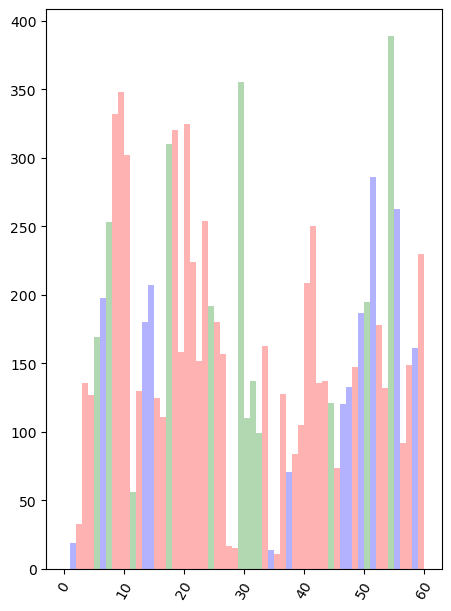

In [8]:
plt.figure(figsize=(10,7))
plt.subplot(1,2,1)
plt.tight_layout(pad=4.0)
plt.hist(x=train['patientID'], alpha=0.3, color='r', bins=60,range=(0,60))
plt.hist(x=val['patientID'], alpha=0.3, color='b', bins=60, range=(0,60))
plt.hist(x=test['patientID'], alpha=0.3, color='g', bins=60, range=(0,60))
plt.xticks(rotation=60)

In [9]:
INPUT_DIM = (27,27,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 1
BATCH_SIZE = 256
EPOCHS = 50

In [10]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train['isCancerous'] = train['isCancerous'].astype('str')
val['isCancerous'] = val['isCancerous'].astype('str')
test['isCancerous'] = test['isCancerous'].astype('str')

train_gen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_gen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
test_gen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

train_generator = train_gen.flow_from_dataframe(
        dataframe=train,
        directory='./Image_classification_data/patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=BATCH_SIZE,
        class_mode='binary')

validation_generator = val_gen.flow_from_dataframe(
        dataframe=val,
        directory='./Image_classification_data/patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=BATCH_SIZE,
        class_mode='binary')

test_generator = test_gen.flow_from_dataframe(
        dataframe=test,
        directory='./Image_classification_data/patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=1,
        class_mode='binary')

Found 5671 validated image filenames belonging to 2 classes.
Found 1839 validated image filenames belonging to 2 classes.
Found 2386 validated image filenames belonging to 2 classes.


## Baseline

In [12]:
model = tf.keras.Sequential([
    layers.Flatten(input_shape=INPUT_DIM),
    layers.Dense(OUTPUT_CLASSES, activation="sigmoid")
])

2023-05-12 12:17:55.191212: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 2187)              0         
                                                                 
 dense (Dense)               (None, 1)                 2188      
                                                                 
Total params: 2,188
Trainable params: 2,188
Non-trainable params: 0
_________________________________________________________________


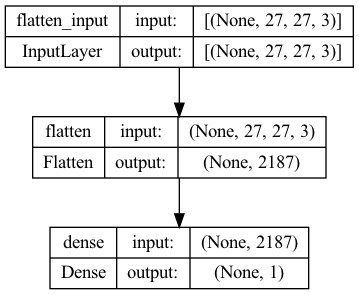

In [14]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [15]:
from keras.optimizers import SGD
opt = SGD(learning_rate=0.01)
model.compile(optimizer = opt,
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=[tf.keras.metrics.BinaryAccuracy(), f1_m,precision_m, recall_m])

history = model.fit(train_generator, validation_data = validation_generator, epochs=EPOCHS)

Epoch 1/50
23/23 [==============================] - 3s 97ms/step - loss: 1.0445 - binary_accuracy: 0.4985 - f1_m: 0.2626 - precision_m: 0.1846 - recall_m: 0.4621 - val_loss: 0.7702 - val_binary_accuracy: 0.5030 - val_f1_m: 0.6767 - val_precision_m: 0.5125 - val_recall_m: 1.0000
Epoch 2/50
23/23 [==============================] - 1s 56ms/step - loss: 0.8703 - binary_accuracy: 0.5458 - f1_m: 0.3119 - precision_m: 0.2951 - recall_m: 0.4699 - val_loss: 0.6207 - val_binary_accuracy: 0.6514 - val_f1_m: 0.7478 - val_precision_m: 0.6035 - val_recall_m: 0.9872
Epoch 3/50
23/23 [==============================] - 1s 51ms/step - loss: 0.8553 - binary_accuracy: 0.5909 - f1_m: 0.3333 - precision_m: 0.3048 - recall_m: 0.5002 - val_loss: 1.1526 - val_binary_accuracy: 0.4970 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 4/50
23/23 [==============================] - 1s 54ms/step - loss: 0.7519 - binary_accuracy: 0.5890 - f1_m: 0.3328 - precision_m: 0.3643 - recall

23/23 [==============================] - 1s 49ms/step - loss: 0.3445 - binary_accuracy: 0.8692 - f1_m: 0.8328 - precision_m: 0.8537 - recall_m: 0.8182 - val_loss: 0.5048 - val_binary_accuracy: 0.7444 - val_f1_m: 0.6777 - val_precision_m: 0.9615 - val_recall_m: 0.5241
Epoch 31/50
23/23 [==============================] - 1s 52ms/step - loss: 0.3500 - binary_accuracy: 0.8602 - f1_m: 0.8141 - precision_m: 0.8456 - recall_m: 0.7977 - val_loss: 0.3955 - val_binary_accuracy: 0.8401 - val_f1_m: 0.8197 - val_precision_m: 0.9228 - val_recall_m: 0.7383
Epoch 32/50
23/23 [==============================] - 1s 49ms/step - loss: 0.3444 - binary_accuracy: 0.8642 - f1_m: 0.8132 - precision_m: 0.8530 - recall_m: 0.7915 - val_loss: 0.4410 - val_binary_accuracy: 0.7874 - val_f1_m: 0.8177 - val_precision_m: 0.7143 - val_recall_m: 0.9581
Epoch 33/50
23/23 [==============================] - 1s 47ms/step - loss: 0.3531 - binary_accuracy: 0.8588 - f1_m: 0.8126 - precision_m: 0.8379 - recall_m: 0.8036 - val_los

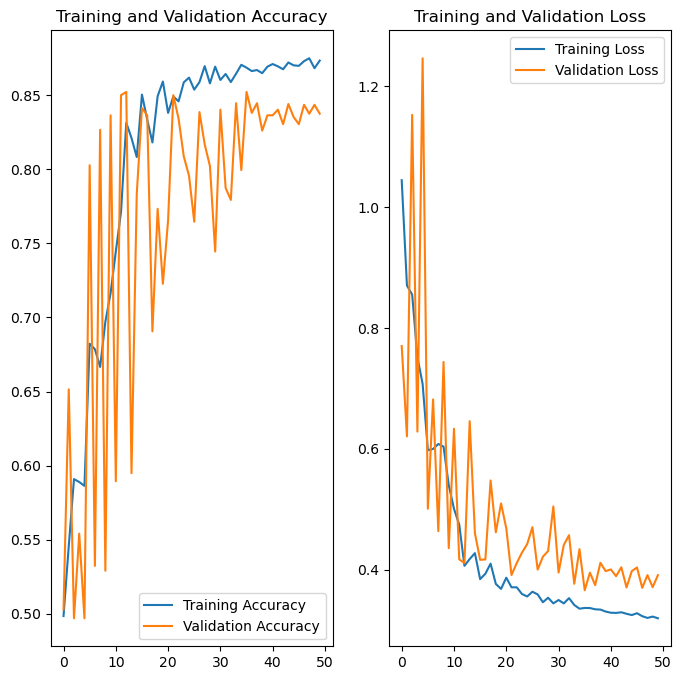

In [16]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)

plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## CNN

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = tf.keras.Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(27, 27, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 25, 25, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 512)         295424    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 1, 1, 512)       

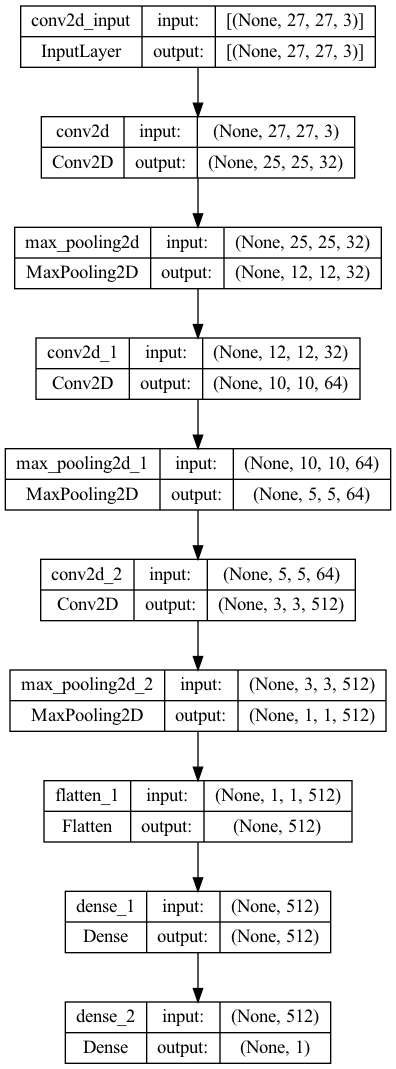

In [19]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [20]:
model.compile(optimizer = 'adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

history = model.fit(train_generator, validation_data = validation_generator, epochs=EPOCHS)

Epoch 1/50
23/23 [==============================] - 5s 176ms/step - loss: 0.6319 - binary_accuracy: 0.6345 - val_loss: 0.8024 - val_binary_accuracy: 0.4986
Epoch 2/50
23/23 [==============================] - 4s 162ms/step - loss: 0.4849 - binary_accuracy: 0.7685 - val_loss: 0.3738 - val_binary_accuracy: 0.8603
Epoch 3/50
23/23 [==============================] - 4s 159ms/step - loss: 0.3451 - binary_accuracy: 0.8535 - val_loss: 0.6067 - val_binary_accuracy: 0.7433
Epoch 4/50
23/23 [==============================] - 3s 125ms/step - loss: 0.3181 - binary_accuracy: 0.8639 - val_loss: 0.3525 - val_binary_accuracy: 0.8559
Epoch 5/50
23/23 [==============================] - 3s 111ms/step - loss: 0.2890 - binary_accuracy: 0.8790 - val_loss: 0.3905 - val_binary_accuracy: 0.8358
Epoch 6/50
23/23 [==============================] - 3s 135ms/step - loss: 0.3372 - binary_accuracy: 0.8503 - val_loss: 0.3611 - val_binary_accuracy: 0.8494
Epoch 7/50
23/23 [==============================] - 3s 128ms/ste

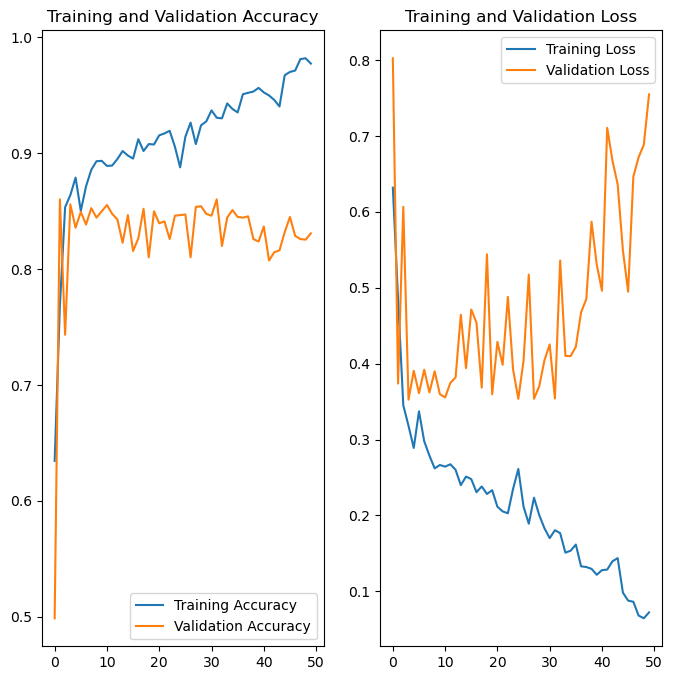

In [21]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)

plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Overfitting

In [22]:
train_gen = ImageDataGenerator(rescale=1./255,
                               rotation_range=40,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               shear_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               data_format='channels_last')

train_generator = train_gen.flow_from_dataframe(
        dataframe=train,
        directory='./Image_classification_data/patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=BATCH_SIZE,
        class_mode='binary')

Found 5671 validated image filenames belonging to 2 classes.


In [23]:
model = tf.keras.Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(27, 27, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

In [24]:
model.compile(optimizer = 'adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

history = model.fit(train_generator, validation_data = validation_generator, epochs=EPOCHS)

Epoch 1/50
23/23 [==============================] - 4s 170ms/step - loss: 0.6401 - binary_accuracy: 0.5997 - val_loss: 0.6199 - val_binary_accuracy: 0.5421
Epoch 2/50
23/23 [==============================] - 4s 191ms/step - loss: 0.5104 - binary_accuracy: 0.7685 - val_loss: 0.5351 - val_binary_accuracy: 0.7232
Epoch 3/50
23/23 [==============================] - 4s 170ms/step - loss: 0.3929 - binary_accuracy: 0.8223 - val_loss: 0.5416 - val_binary_accuracy: 0.7553
Epoch 4/50
23/23 [==============================] - 4s 166ms/step - loss: 0.3650 - binary_accuracy: 0.8374 - val_loss: 0.3833 - val_binary_accuracy: 0.8358
Epoch 5/50
23/23 [==============================] - 4s 167ms/step - loss: 0.3302 - binary_accuracy: 0.8565 - val_loss: 0.5726 - val_binary_accuracy: 0.7814
Epoch 6/50
23/23 [==============================] - 4s 187ms/step - loss: 0.3155 - binary_accuracy: 0.8709 - val_loss: 0.5587 - val_binary_accuracy: 0.7879
Epoch 7/50
23/23 [==============================] - 4s 167ms/ste

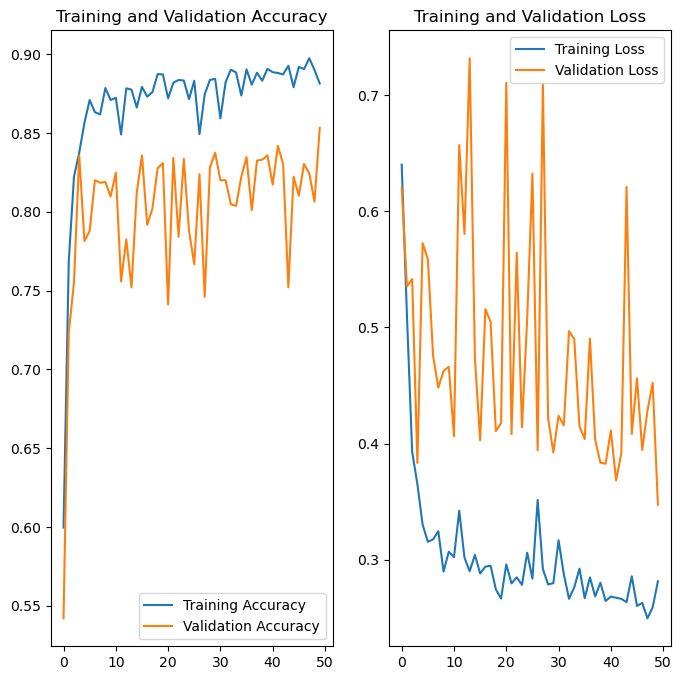

In [25]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)

plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Adding Extra data sheet

In [26]:
extra_data = pd.read_csv('./Image_classification_data/data_labels_extraData.csv')

### Simply adding new data

In [27]:
# new image dataset based on new data
extra_data['isCancerous'] = extra_data['isCancerous'].astype('str')
extra_gen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

extra_generator = extra_gen.flow_from_dataframe(
        dataframe=extra_data,
        directory='./Image_classification_data/patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=BATCH_SIZE,
        class_mode='binary')


# model.compile(optimizer = SGD(learning_rate=0.001, momentum=0.9),
#               loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
#               metrics=[tf.keras.metrics.BinaryAccuracy()])

history = model.fit(extra_generator,validation_data = validation_generator, epochs=25)

#https://machinelearningmastery.com/update-neural-network-models-with-more-data/

Found 10384 validated image filenames belonging to 2 classes.
Epoch 1/25
41/41 [==============================] - 6s 146ms/step - loss: 0.3169 - binary_accuracy: 0.8701 - val_loss: 0.9538 - val_binary_accuracy: 0.6645
Epoch 2/25
41/41 [==============================] - 5s 130ms/step - loss: 0.2280 - binary_accuracy: 0.9076 - val_loss: 1.0626 - val_binary_accuracy: 0.6264
Epoch 3/25
41/41 [==============================] - 5s 115ms/step - loss: 0.2129 - binary_accuracy: 0.9159 - val_loss: 0.9375 - val_binary_accuracy: 0.6770
Epoch 4/25
41/41 [==============================] - 5s 117ms/step - loss: 0.2088 - binary_accuracy: 0.9178 - val_loss: 0.6381 - val_binary_accuracy: 0.7537
Epoch 5/25
41/41 [==============================] - 5s 125ms/step - loss: 0.1927 - binary_accuracy: 0.9236 - val_loss: 0.8601 - val_binary_accuracy: 0.6993
Epoch 6/25
41/41 [==============================] - 5s 125ms/step - loss: 0.1994 - binary_accuracy: 0.9207 - val_loss: 0.9713 - val_binary_accuracy: 0.6732
Ep

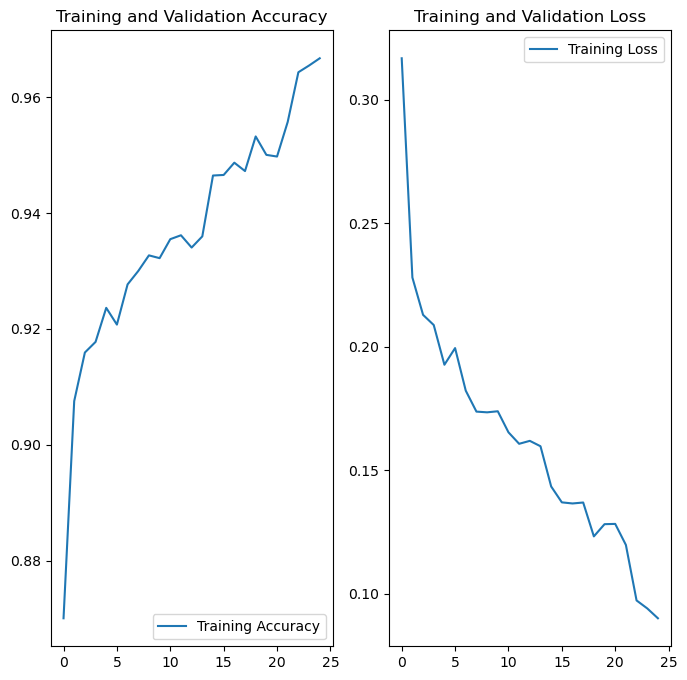

In [28]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(25)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)

plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### rebuilding using old and new datasets

In [35]:
all_data = train.append(extra_data)
all_data

/var/folders/y9/zqghcs590x78pdxdn844njrm0000gn/T/ipykernel_4552/729938618.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_data = train.append(extra_data)


,InstanceID,patientID,ImageName,cellType,isCancerous,epithelial,fibroblast,inflammatory,others
3,3892,52,3892.png,2.0,1,1.0,0.0,0.0,0.0
4,7949,9,7949.png,2.0,1,1.0,0.0,0.0,0.0
5,3873,52,3873.png,2.0,1,1.0,0.0,0.0,0.0
6,18915,3,18915.png,1.0,0,0.0,0.0,1.0,0.0
7,7964,9,7964.png,2.0,1,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
10379,20028,99,20028.png,NaN,0,NaN,NaN,NaN,NaN
10380,20029,99,20029.png,NaN,0,NaN,NaN,NaN,NaN
10381,20030,99,20030.png,NaN,0,NaN,NaN,NaN,NaN
10382,20031,99,20031.png,NaN,0,NaN,NaN,NaN,NaN


In [ ]:
# new image dataset based on new data
all_data['isCancerous'] = all_data['isCancerous'].astype('str')

all_gen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

all_generator = train_gen.flow_from_dataframe(
        dataframe=all_data,
        directory='./Image_classification_data/patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=BATCH_SIZE,
        class_mode='binary')


model.compile(optimizer = 'adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

history = model.fit(all_generator, validation_data = validation_generator, epochs=EPOCHS)

#https://machinelearningmastery.com/update-neural-network-models-with-more-data/

Found 16055 validated image filenames belonging to 2 classes.
Epoch 1/50
63/63 [==============================] - 12s 186ms/step - loss: 0.5978 - binary_accuracy: 0.8422 - val_loss: 0.7950 - val_binary_accuracy: 0.6835
Epoch 2/50
63/63 [==============================] - 12s 182ms/step - loss: 0.3131 - binary_accuracy: 0.8689 - val_loss: 0.6901 - val_binary_accuracy: 0.7210
Epoch 3/50
63/63 [==============================] - 11s 170ms/step - loss: 0.2983 - binary_accuracy: 0.8736 - val_loss: 0.7216 - val_binary_accuracy: 0.7129
Epoch 4/50
63/63 [==============================] - 11s 167ms/step - loss: 0.2918 - binary_accuracy: 0.8790 - val_loss: 0.6739 - val_binary_accuracy: 0.7254
Epoch 5/50
63/63 [==============================] - 11s 167ms/step - loss: 0.2846 - binary_accuracy: 0.8805 - val_loss: 0.6358 - val_binary_accuracy: 0.7281
Epoch 6/50
63/63 [==============================] - 11s 168ms/step - loss: 0.2822 - binary_accuracy: 0.8815 - val_loss: 0.5582 - val_binary_accuracy: 0.7

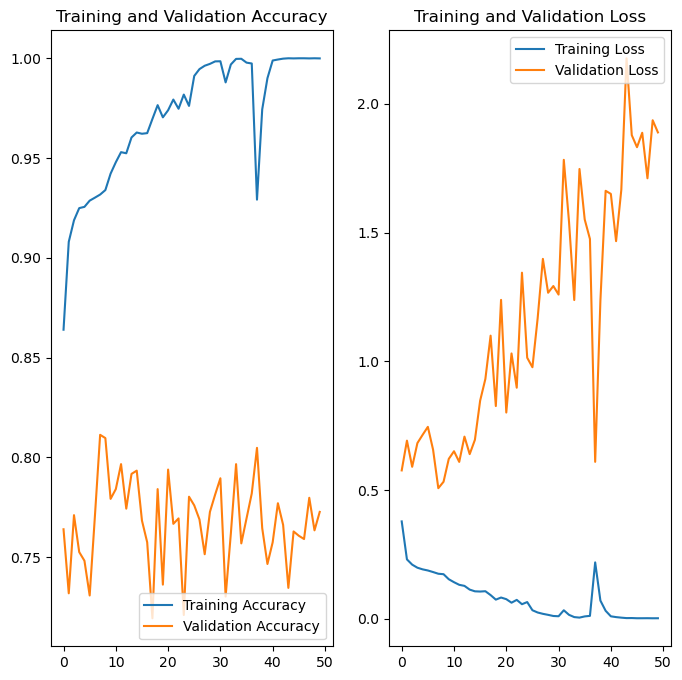

In [36]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)

plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Testing

In [32]:
results=model.evaluate(test_generator)
print("Loss: {}".format(round(results[0], 3)))
print("Accuracy: {}".format(round(results[1], 3)))

2386/2386 [==============================] - 2s 954us/step - loss: 1.0095 - binary_accuracy: 0.8609
Loss: 1.009
Accuracy: 0.861
